<a href="https://colab.research.google.com/github/Nick-FF/NeuroNets_Begining/blob/Less5/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import os
import datetime

для использования TensorBoard в колаборатории
https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=**hzm9DNVILxJe**

In [3]:
%load_ext tensorboard

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

Читаем данные из файла со значениями (потребление энергии дневные отсчеты)

In [7]:
files.upload()
!ls

KeyboardInterrupt: ignored

In [ ]:
#df = pd.read_csv('my_BRENT2019.csv')
# df = pd.read_csv('/content/PJME_Потребление_энергии_D.csv')
df = pd.read_csv('/content/PJME_Потребление_энергии_D.csv')
df.index = df.Date
df.drop(['Date'],axis=1,inplace = True)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/airline-passengers.csv')
df.index = df.Month
df.drop(['Month'],axis=1,inplace = True)

In [7]:
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Данные о потреблении энергии+ индексы (дата)

Сортируем по дате

In [8]:


df.sort_index(ascending=True, inplace=True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121



Для PJME  все лишнее уже отбросили

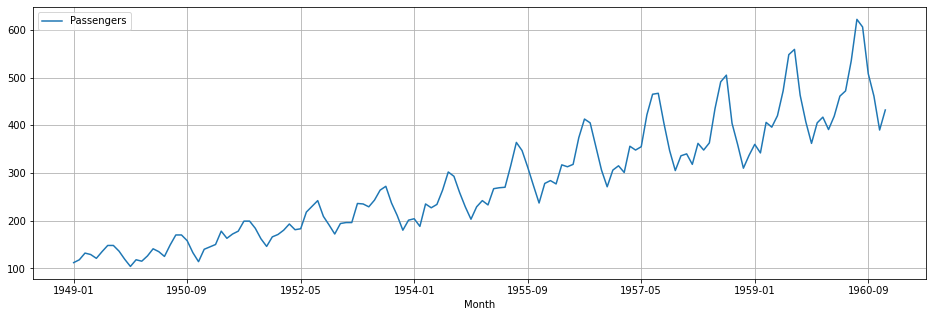

In [9]:
df.plot( figsize = (16,5))
#df['PJME_MW'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [10]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Добавим дату как признаки:
как "день в году"/366 и (год-2002)

In [11]:
df.index

Index(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10',
       ...
       '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
       '1960-09', '1960-10', '1960-11', '1960-12'],
      dtype='object', name='Month', length=144)

In [ ]:
# df['day'] = pd.to_datetime(df.index).dayofyear/366.0
# df['year'] = pd.to_datetime(df.index).year - 2002
# df.head()

,PJME_MW,day,year
Date,,,
2002-01-01,714857.0,0.002732,0
2002-01-02,822277.0,0.005464,0
2002-01-03,828285.0,0.008197,0
2002-01-04,809171.0,0.010929,0
2002-01-05,729723.0,0.013661,0


In [12]:
#
data = df.copy() # берем все что есть

In [13]:
data.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Делаем нормализацию

In [14]:
def normalize(data, data_mean = 0,data_std= 0 ):
    
    if data_std == 0:
      data_mean = data.mean(axis=0)
      data_std = data.std(axis=0)
    return (data - data_mean) / data_std, data_mean,data_std

Можно (и нужно заменять на sklearn StandadScaler) т.к. это нужно дополнительно сохранять для обработки реальных данных , но тут сделаем без привлечения внешних модулей

In [33]:
train_split = 1500
_,d_m,d_s =  normalize(data.iloc[:train_split,0].values)
data.iloc[:, 0]= (data.iloc[:, 0].values - d_m) / d_s

In [34]:
data.head()

,Passengers
Month,
1949-01,-1.407779
1949-02,-1.357590
1949-03,-1.240483
1949-04,-1.265578
1949-05,-1.332496


In [49]:
df.index.size

144

Создаем данные для обучения

In [51]:
# список признаков, по которым будем учить
#channelIndexes = [0,1, 2, 3] # BRENT
channelIndexes = [0]

# длина теста
valLen = 100
# длина истории для работы
xLen = 14
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
# train_split = data.shape[0] - valLen - bias
# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]



In [37]:
train_data.head(3)

,Passengers
Month,
1949-01,-1.407779
1949-02,-1.357590
1949-03,-1.240483


Формируем параметры для генерации выборки

In [38]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10


Выделяем части на обучение и проверку

In [39]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)




In [40]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(130, 1)
(130,)
(0, 1)
(0,)


Посмотрим на них

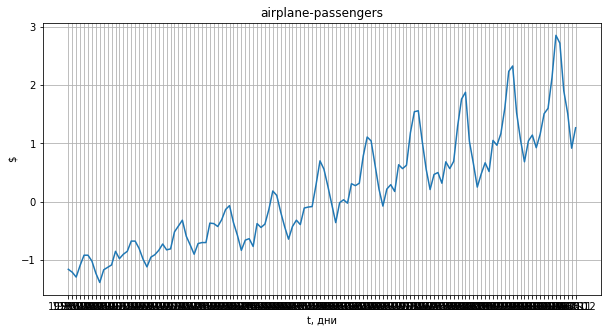

In [42]:
plt.figure(figsize=(10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
#plt.title('стоимость BRENT в 2010-2018')
plt.title('airplane-passengers')
plt.show()

Используем механизм формирования пакетов для обучения

In [53]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)


ValueError: ignored

In [54]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

NameError: ignored

In [ ]:
inputs[1,0,:]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-0.1228208 ,  0.22677596,  4.        ])>

In [ ]:
inputs[1,:,0]

<tf.Tensor: shape=(14,), dtype=float64, numpy=
array([-0.1228208 , -0.70645404, -0.82580536, -0.286306  , -0.32342191,
       -0.51804542, -0.55322659, -0.7364242 , -1.39980142, -1.85126115,
       -0.71649276, -0.57830515, -0.33576042, -0.43701465])>

In [ ]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.43701465043065785>

In [ ]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [ ]:
inputs[0,:,0]

<tf.Tensor: shape=(14,), dtype=float64, numpy=
array([-0.780914  , -0.79150029,  0.07692246,  0.60051499,  0.16592945,
        0.00276366, -0.3028699 , -0.9832217 , -1.18820334, -0.29480242,
        0.15247755, -0.05416504,  0.21095769, -0.11997345])>

In [ ]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-1.1740669918762772>

In [ ]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

**сеть:  LSTM слои+Conv1D +Dense слой.**

Epoch 1/10
47/47 [==============================] - 15s 46ms/step - loss: 0.6889 - mae: 0.6284 - val_loss: 0.7265 - val_mae: 0.6658
Epoch 2/10
47/47 [==============================] - 1s 21ms/step - loss: 0.5513 - mae: 0.5573 - val_loss: 0.5682 - val_mae: 0.5575
Epoch 3/10
47/47 [==============================] - 1s 22ms/step - loss: 0.5258 - mae: 0.5530 - val_loss: 0.6380 - val_mae: 0.5972
Epoch 4/10
47/47 [==============================] - 1s 22ms/step - loss: 0.4723 - mae: 0.5210 - val_loss: 0.5659 - val_mae: 0.5545
Epoch 5/10
47/47 [==============================] - 1s 22ms/step - loss: 0.4387 - mae: 0.5092 - val_loss: 0.5405 - val_mae: 0.5394
Epoch 6/10
47/47 [==============================] - 1s 22ms/step - loss: 0.3764 - mae: 0.4749 - val_loss: 0.4209 - val_mae: 0.4762
Epoch 7/10
47/47 [==============================] - 1s 21ms/step - loss: 0.3310 - mae: 0.4475 - val_loss: 0.3425 - val_mae: 0.4347
Epoch 8/10
47/47 [==============================] - 1s 22ms/step - loss: 0.2955 - 

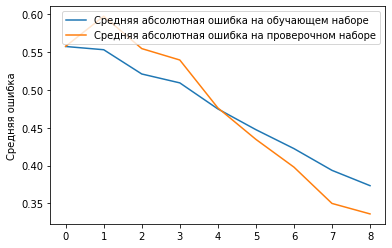

In [ ]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#!kill 546

In [ ]:
%tensorboard --logdir logs2   

In [ ]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/10
47/47 [==============================] - 1s 20ms/step - loss: 0.2097 - mae: 0.3493 - val_loss: 0.1836 - val_mae: 0.3315
Epoch 2/10
47/47 [==============================] - 1s 21ms/step - loss: 0.2165 - mae: 0.3592 - val_loss: 0.1857 - val_mae: 0.3269
Epoch 3/10
47/47 [==============================] - 1s 21ms/step - loss: 0.2086 - mae: 0.3499 - val_loss: 0.1716 - val_mae: 0.3158
Epoch 4/10
47/47 [==============================] - 1s 22ms/step - loss: 0.1919 - mae: 0.3333 - val_loss: 0.1592 - val_mae: 0.3038
Epoch 5/10
47/47 [==============================] - 1s 22ms/step - loss: 0.1825 - mae: 0.3241 - val_loss: 0.1694 - val_mae: 0.3058
Epoch 6/10
47/47 [==============================] - 1s 21ms/step - loss: 0.1897 - mae: 0.3312 - val_loss: 0.2235 - val_mae: 0.3434


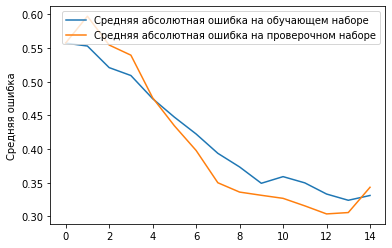

In [ ]:

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#!kill 546

In [ ]:
%tensorboard --logdir logs2

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [ ]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

Валидация:

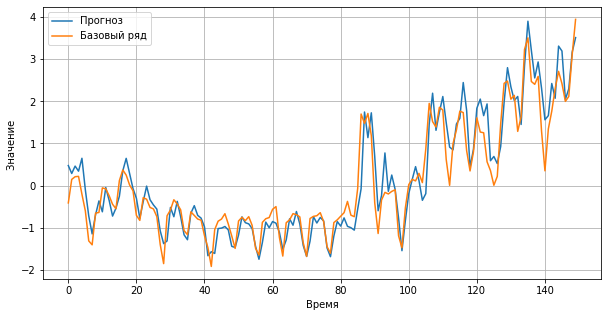

In [ ]:
start = 0
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Тренировочные даннные:

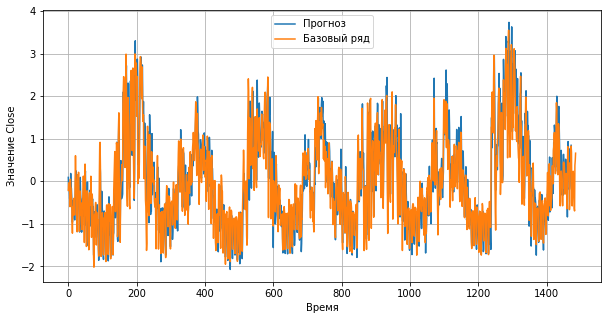

In [ ]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).


In [ ]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

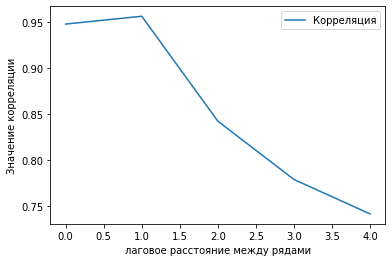

In [ ]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 150 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

Хорошая картинки лаговой корреляции ряда yValF[:-i], yPredVal[i:]

In [ ]:
corr

[0.9482831821334312,
 0.9568169423105596,
 0.8423845461810958,
 0.7788029041087449,
 0.741240036909449]

Можно добавить обучения на другом размере сети

Epoch 1/100
47/47 [==============================] - 3s 26ms/step - loss: 0.5676 - mae: 0.5773 - val_loss: 0.4732 - val_mae: 0.4936
Epoch 2/100
47/47 [==============================] - 1s 15ms/step - loss: 0.4494 - mae: 0.5048 - val_loss: 0.3950 - val_mae: 0.4585
Epoch 3/100
47/47 [==============================] - 1s 15ms/step - loss: 0.3851 - mae: 0.4728 - val_loss: 0.3288 - val_mae: 0.4240
Epoch 4/100
47/47 [==============================] - 1s 15ms/step - loss: 0.3448 - mae: 0.4521 - val_loss: 0.3129 - val_mae: 0.4130
Epoch 5/100
47/47 [==============================] - 1s 16ms/step - loss: 0.3206 - mae: 0.4385 - val_loss: 0.2947 - val_mae: 0.3989
Epoch 6/100
47/47 [==============================] - 1s 16ms/step - loss: 0.3009 - mae: 0.4265 - val_loss: 0.2785 - val_mae: 0.3842
Epoch 7/100
47/47 [==============================] - 1s 16ms/step - loss: 0.2834 - mae: 0.4142 - val_loss: 0.2648 - val_mae: 0.3712
Epoch 8/100
47/47 [==============================] - 1s 16ms/step - loss: 0.

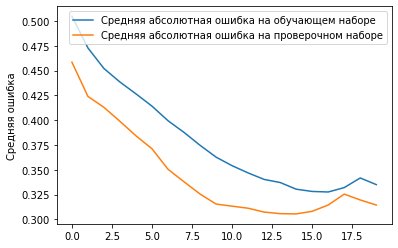

In [ ]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))

model.add(Flatten())                          # (None, n_Dense*n_lstm)
model.add(Dense(8, activation="linear"))      # (None,n_Dense)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

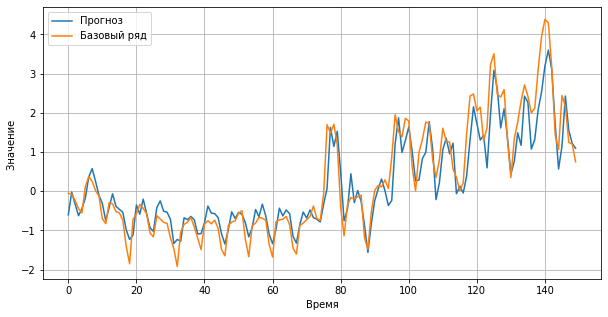

In [ ]:
start = 10
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Проверим лаговые корреляции:


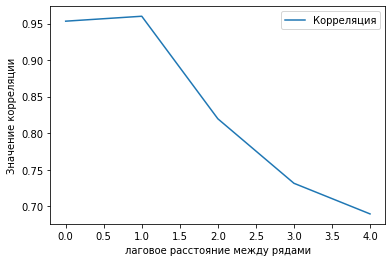

In [ ]:
corr = []
start = 10 # начальная точка для проверки корреляций рядов
step = 150 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

In [ ]:
corr

[0.9532366960450543,
 0.9599928362336957,
 0.8196875086552545,
 0.7314338586205936,
 0.6895203023340918]

## **Дополнительные материалы**
простой ресурс про методы для работы с временными рядами

http://statsoft.ru/home/textbook/modules/sttimser.html


Анализ временных рядов 

https://habr.com/ru/company/ods/blog/327242/